In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.datamodules import chipmultilabel

from importlib import reload
reload(chipmultilabel)

<module 'earthtext.datamodules.chipmultilabel' from '/home/ubuntu/earth-text/src/earthtext/datamodules/chipmultilabel.py'>

## setup dataloader

In [7]:
conf = OmegaConf.load("../../configs/osmencoder.yaml")
dl = hydra.utils.instantiate(conf.dataloader)

2024-04-12 01:19:54.305 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:76 - checking chip files for train split
100% (60396 of 60396) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-04-12 01:19:57.787 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:80 - read train split with 60295 chip files (out of 60396)
2024-04-12 01:19:57.788 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:82 - max cache size is -1
2024-04-12 01:19:58.701 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:76 - checking chip files for val split
100% (12304 of 12304) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-12 01:19:59.407 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:80 - read val split with 12288 chip files (out of 12304)
2024-04-12 01:19:59.408 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:82 - max cache size is -1
2024-04-12 01:20:00.

## setup model and optimizer

In [21]:
dltrain = dl.train_dataloader()

m = hydra.utils.instantiate(conf.model)

optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)

sum([np.product(p.shape) for p in m.parameters()])

1235840

## train loop

In [22]:
n_epochs = 10

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = torch.cat([batch['osm_ohecount'], batch['osm_ohearea'], batch['osm_ohelength']], axis=1).type(torch.float)
        t = batch['embedding']

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = torch.sqrt(torch.mean( (o-t)**2 ))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3768 loss 0.07038 params 0.035660131
epoch   1 step 3768 loss 0.06352 params 0.0672393
epoch   2 step 3768 loss 0.05883 params 0.0993759
epoch   3 step 3768 loss 0.05445 params 0.1311210
epoch   4 step 3768 loss 0.05057 params 0.1630312
epoch   5 step 3768 loss 0.04747 params 0.1952353
epoch   6 step 3768 loss 0.04459 params 0.2276832
epoch   7 step 3768 loss 0.04155 params 0.2604507
epoch   8 step 3768 loss 0.03868 params 0.2931403
epoch   9 step 3768 loss 0.03655 params 0.3257815


(0.0, 0.1)

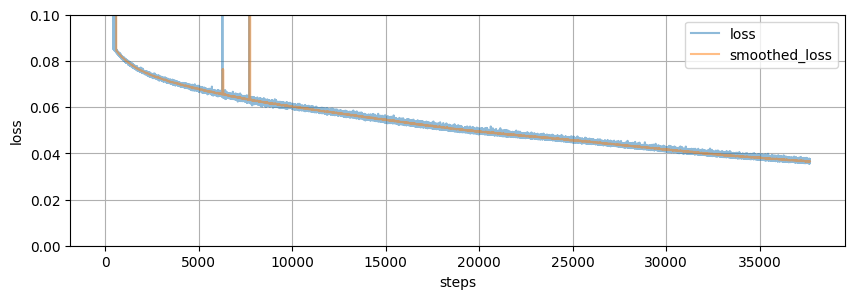

In [25]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
plt.ylim(0,.1)

## measure loss on full train,val,test datasets

In [28]:
def get_targets_and_predictions(dataloader):
    targets = []
    predictions = []
    for batch in pbar(dataloader):
        x = torch.cat([batch['osm_ohecount'], batch['osm_ohearea'], batch['osm_ohelength']], axis=1).type(torch.float)
        t = batch['embedding']
    
        o = m(x)
    
        for ti in t.detach().numpy():
            targets.append(ti)
    
        for oi in o.detach().numpy():
            predictions.append(oi)
        
    targets = np.r_[targets]
    predictions = np.r_[predictions]
    return targets, predictions

In [29]:
tr_targets, tr_predictions = get_targets_and_predictions(dl.train_dataloader())

100% (3769 of 3769) |####################| Elapsed Time: 0:00:18 Time:  0:00:180001


In [34]:
ts_targets, ts_predictions = get_targets_and_predictions(dl.test_dataloader())
val_targets, val_predictions = get_targets_and_predictions(dl.val_dataloader())

100% (839 of 839) |######################| Elapsed Time: 0:00:12 Time:  0:00:120001
100% (768 of 768) |######################| Elapsed Time: 0:00:11 Time:  0:00:110001


In [35]:
{'train_loss': np.sqrt(np.mean( (tr_predictions-tr_targets)**2 )),
 'test_loss': np.sqrt(np.mean( (ts_predictions-ts_targets)**2 )),
 'val_loss': np.sqrt(np.mean( (val_predictions-val_targets)**2 ))
}

{'train_loss': 0.036478743, 'test_loss': 0.036535006, 'val_loss': 0.03663575}

## targets vs predictions on random chips

In [60]:
idxs = np.random.permutation(len(tr_targets))[:24]

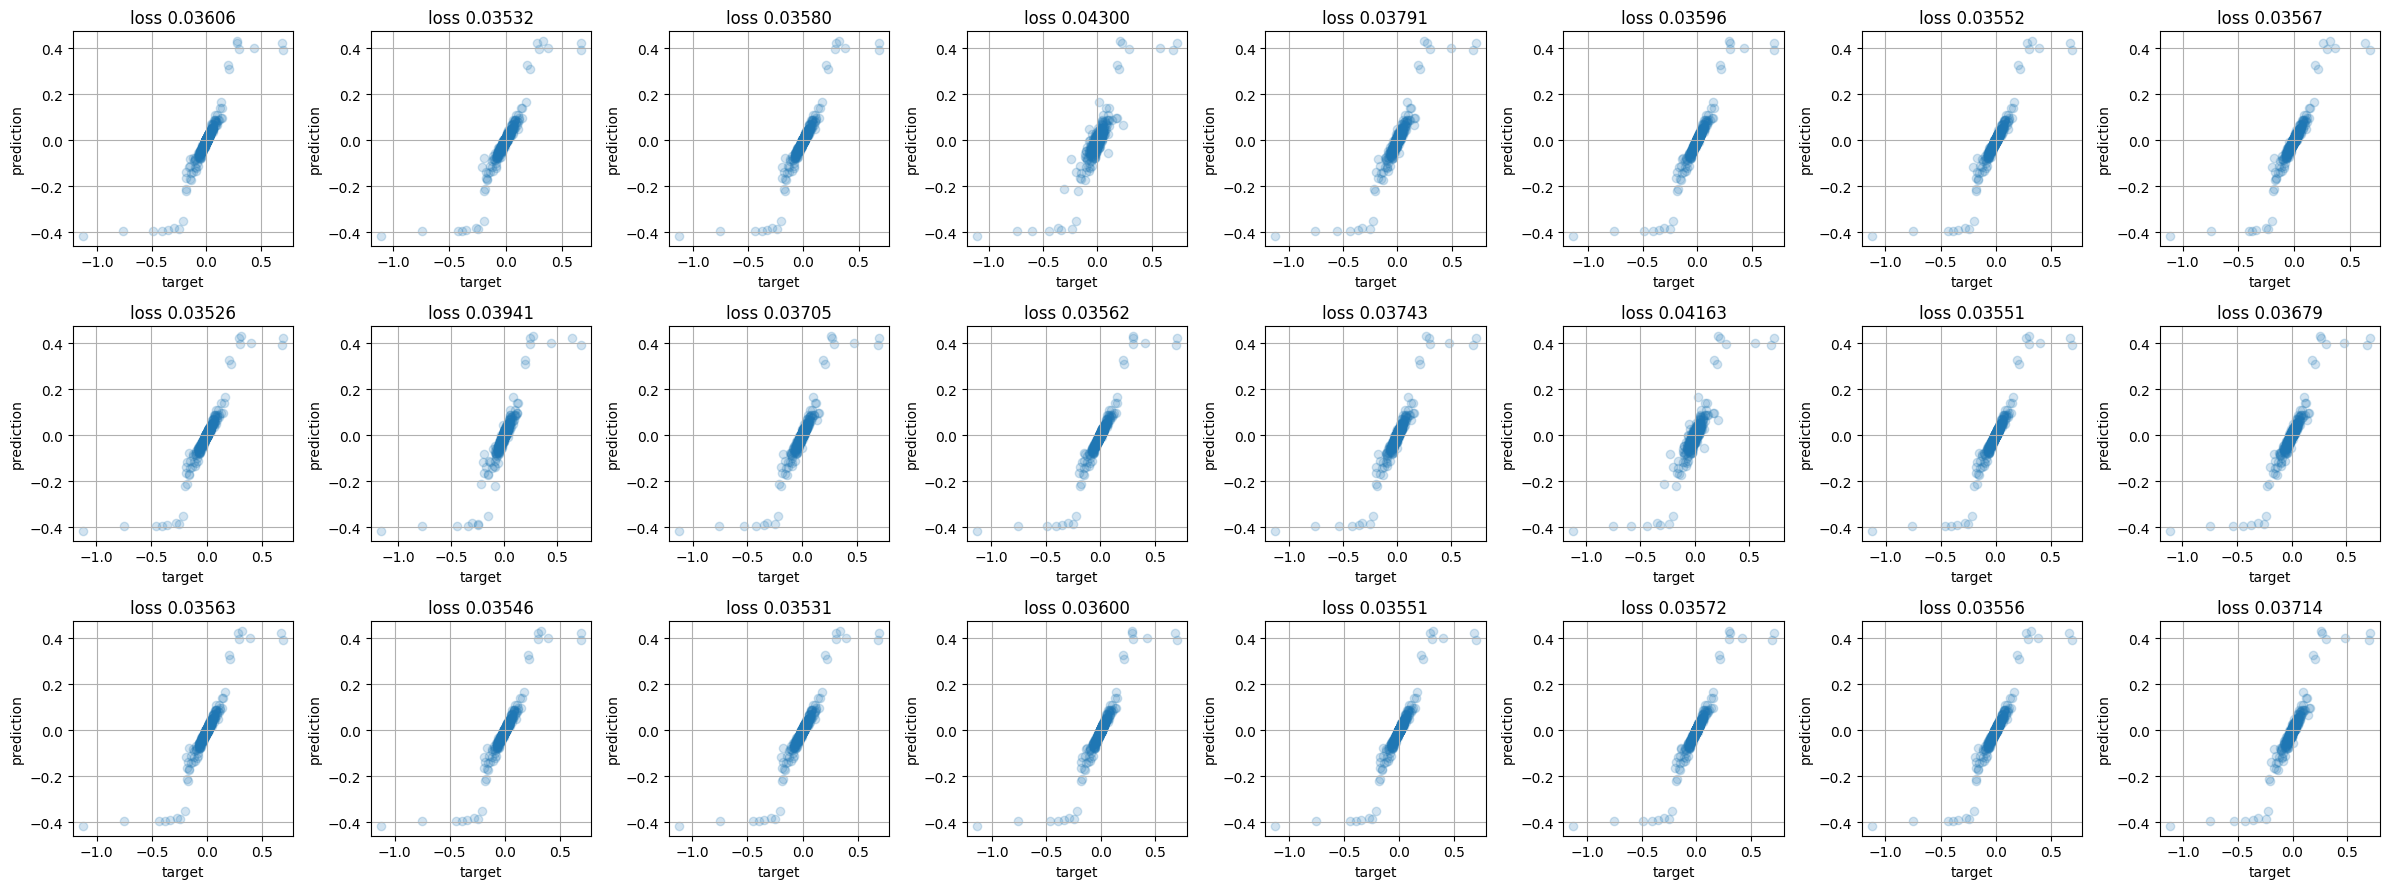

In [62]:
for ax,i in subplots(len(idxs), n_cols=8):
    idx = idxs[i]
    t = tr_targets[idx]
    p = tr_predictions[idx]
    plt.scatter(t, p, alpha=.2)
    plt.grid()
    plt.xlabel("target")
    plt.ylabel("prediction")
    loss = np.sqrt(np.mean ( (t-p)**2 ))
    plt.title(f"loss {loss:.5f}")

## targets vs other targets 

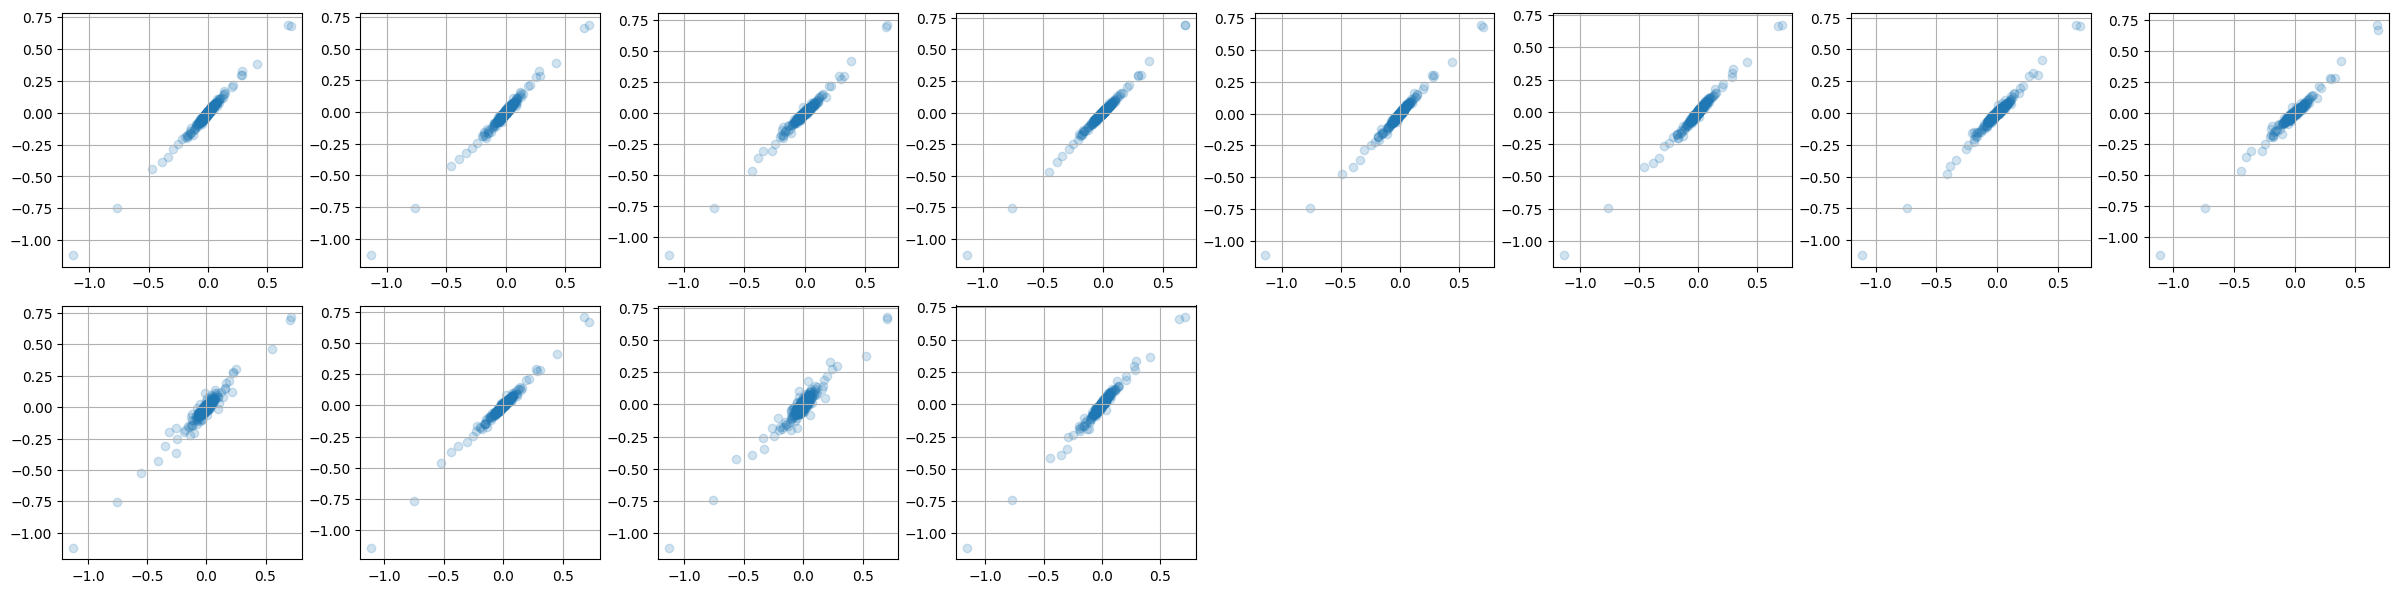

In [64]:
for ax,i in subplots(len(idxs)//2, n_cols=8):
    t1 = tr_targets[i]
    t2 = tr_targets[len(idxs)//2+i]
    plt.scatter(t1, t2, alpha=.2)
    plt.grid()

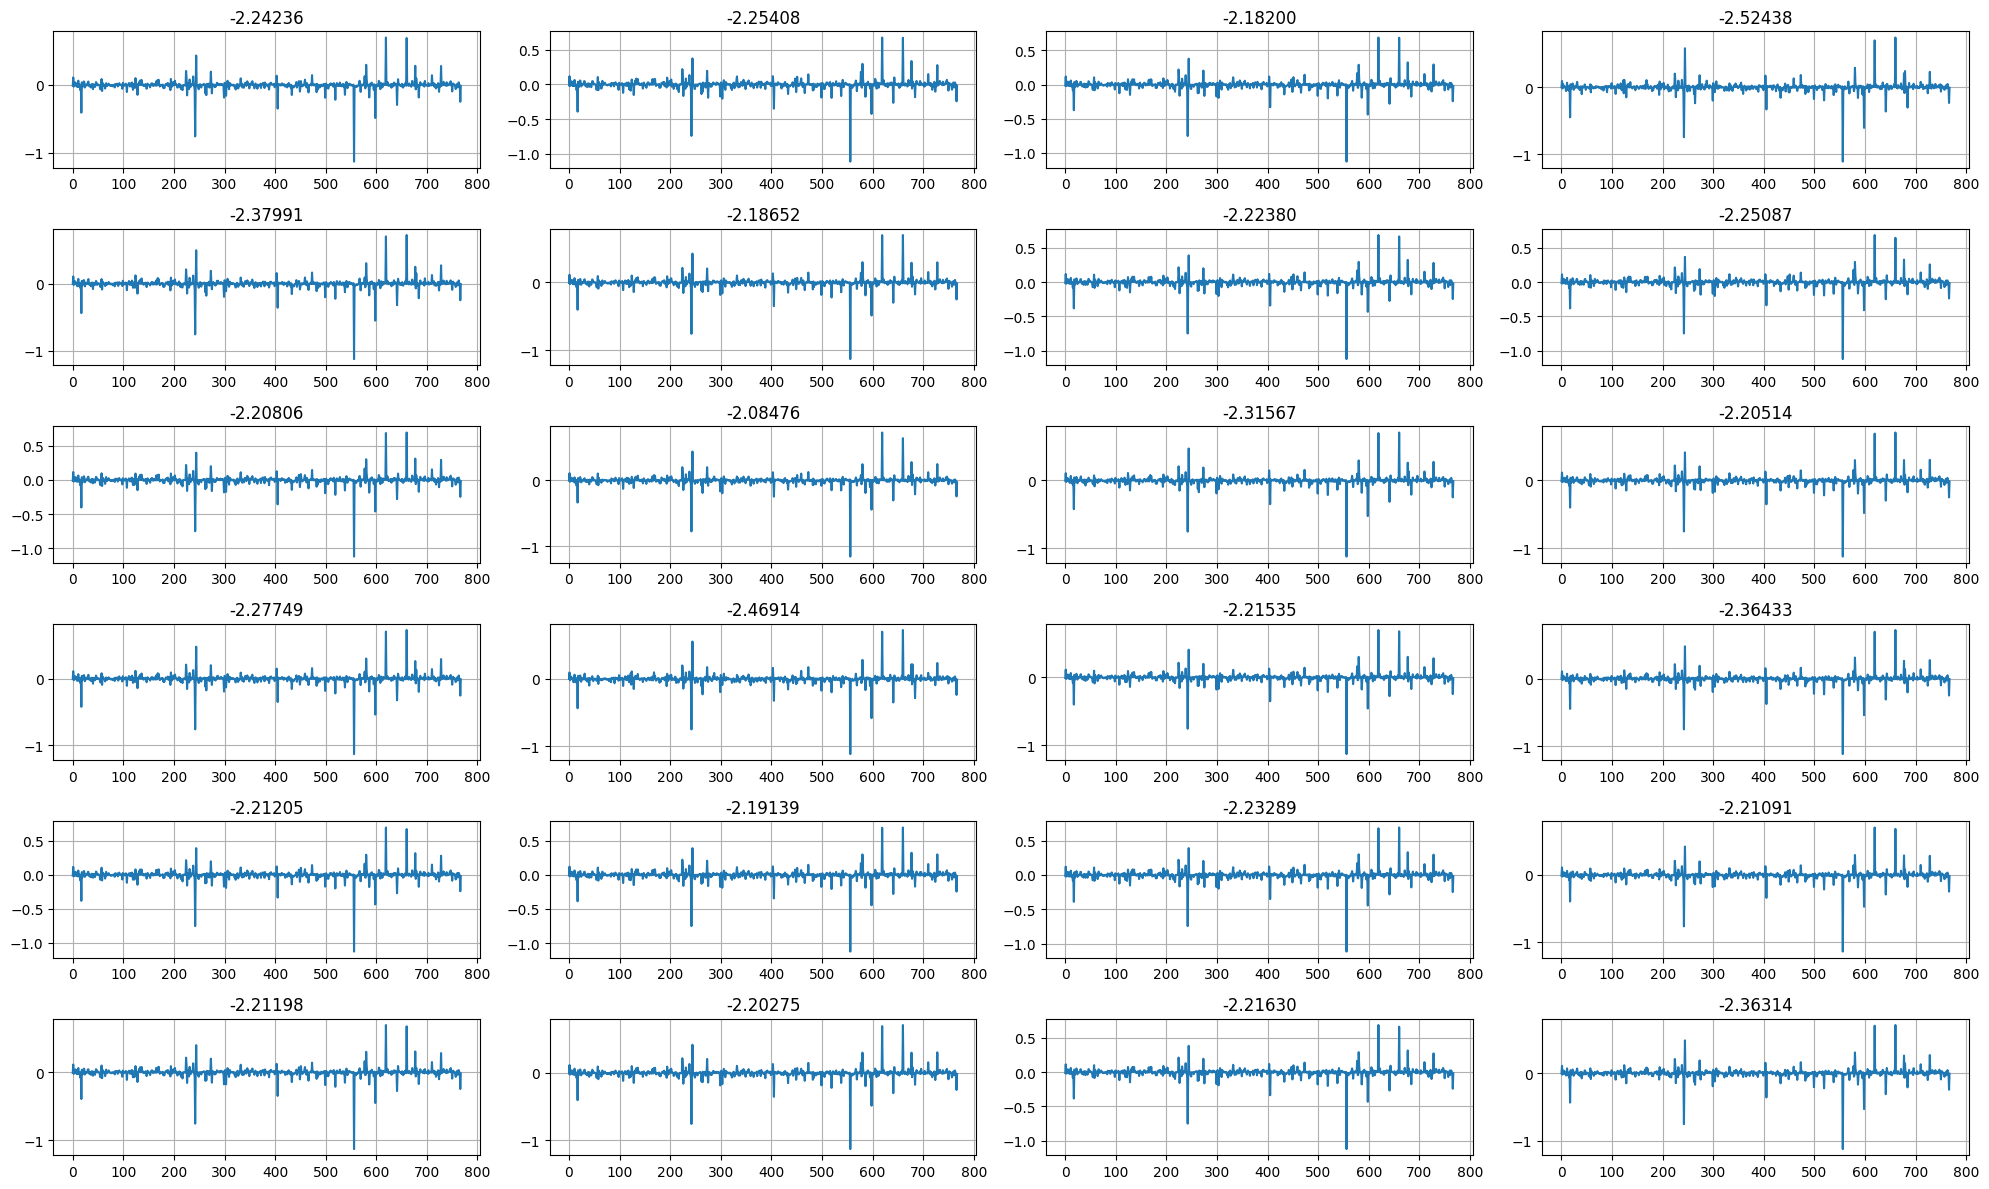

In [73]:
for ax, i in subplots(len(idxs), usizex=5, usizey=2, n_cols=4):
    t = tr_targets[idxs[i]]
    plt.plot(t)
    plt.grid()
    plt.title(f"{sum(t):.5f}")